In [69]:
import gym
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from collections import deque
from tensorflow.keras.losses import huber

In [70]:
# 파라미터 준비
NUM_EPISODES = 10 # 에피소드 수
MAX_STEPS = 20 # 최대 스텝 수
GAMMA = 0.99 # 시간 할인율
WARMUP = 10 # 초기화 시 조작하지 않는 스텝 수

# 검색 파라미터
E_START = 1.0 # ε초기화
E_STOP = 0.01 # ε최종값
E_DECAY_RATE = 0.001 # ε감쇠율

# 메모리 파라미터
MEMORY_SIZE = 10000 # 경험 메모리 사이즈
BATCH_SIZE = 32 # 배치 사이즈

In [71]:
# 행동 평가 함수 정의
class QNetwork:
  # 초기화
  def __init__(self, state_size, action_size):
    # 모델 생성
    self.model = Sequential()
    self.model.add(Dense(16, activation = 'relu', input_dim = state_size))
    self.model.add(Dense(16, activation = 'relu'))
    self.model.add(Dense(16, activation = 'relu'))
    self.model.add(Dense(action_size, activation = 'linear'))
    self.model.summary()
    
    # 모델 컴파일
    self.model.compile(loss = huber, optimizer = Adam(lr = 0.001))

In [72]:
# Experience Replay
# 경험 메모리 정의
class Memory():
  # 초기화
  def __init__(self, memory_size):
    self.buffer = deque(maxlen = memory_size)

  # 경험 추가
  def add(self, experience):
    self.buffer.append(experience)

  # 배치 사이즈만큼의 경험을 랜덤으로(중복 없이) 얻음
  def sample(self, batch_size):
    idx = np.random.choice(np.arange(len(self.buffer)), size = batch_size,
                           replace = False)
    return [self.buffer[i] for i in idx]
  
  # 경험 메모리 사이즈
  def __len__(self):
    return len(self.buffer)

In [73]:
# 환경 생성
env = gym.make('CartPole-v0')
state_size = env.observation_space.shape[0] # 상태 수
action_size = env.action_space.n # 행동 수

/usr/local/lib/python3.7/dist-packages/gym/envs/registration.py:594: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  f"The environment {id} is out of date. You should consider "
/usr/local/lib/python3.7/dist-packages/gym/core.py:318: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  "Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future."
/usr/local/lib/python3.7/dist-packages/gym/wrappers/step_api_compatibility.py:40: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in futu

In [76]:
print(state_size, action_size)

4 2


In [117]:
# Fixed Target Q-Network
# 메인 네트워크 생성
main_qn = QNetwork(state_size, action_size)

# 대상 네트워크 생성
target_qn = QNetwork(state_size, action_size)

# 경험 메모리 생성
memory = Memory(MEMORY_SIZE)

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_56 (Dense)            (None, 16)                80        
                                                                 
 dense_57 (Dense)            (None, 16)                272       
                                                                 
 dense_58 (Dense)            (None, 16)                272       
                                                                 
 dense_59 (Dense)            (None, 2)                 34        
                                                                 
Total params: 658
Trainable params: 658
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_60 (Dense)            (No

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [118]:
# 학습 시작

# 환경 초기화
state = env.reset()
state = np.reshape(state, [1, state_size])

# 에피소드 수만큼 에피소드 반복
total_step = 0 # 총 스텝 수
success_count = 0 # 성공 수
for episode in range(1, NUM_EPISODES+1):
  step = 0 # 스텝 수

  # 대상 네트워크 갱신
  target_qn.model.set_weights(main_qn.model.get_weights())

  # 1 에피소드 루프
  for _ in range(1, MAX_STEPS+1):
    step += 1
    total_step += 1

    # ε를 감소시킴
    epsilon = E_STOP + (E_START - E_STOP) * np.exp(-E_DECAY_RATE * total_step)

    # 랜덤하게 행동 선택
    if epsilon > np.random.rand():
      action = env.action_space.sample()
    # 행동 가치 함수에 따른 행동 선택
    else:
      action = np.argmax(main_qn.model.predict(state)[0])

    # 행동에 맞추어 상태와 보상을 얻음
    next_state, _, done, _ = env.step(action)
    # print('next_state1 = ', next_state)
    next_state = np.reshape(next_state, [1, state_size])
    # print('next_state2 = ', next_state)

    # 에피소드 완료 시
    if done:
      # 보상 지정
      if step >= 190:
        success_count += 1
        reward = 1
      else:
        success_count = 0
        reward = 0

      # 다음 상태에 상태 없음을 대입
      next_state = np.zeros(state.shape)

      # 경험 추가
      if step > WARMUP:
        memory.add((state, action, reward, next_state))
      
    # 에피소드 미완료 시
    else:
      #보상 지정
      reward = 0

      # 경험 추가
      if step > WARMUP:
        memory.add((state, action, reward, next_state))

      # 상태에 다음 상태 대입
      state = next_state

    # 행동 평가 함수 갱신
    if len(memory) >= BATCH_SIZE:
      # 뉴럴 네트워크의 입력과 출력 준비
      inputs = np.zeros((BATCH_SIZE, 4)) # 입력(상태)
      targets = np.zeros((BATCH_SIZE, 2)) # 출력(행동별 가치)

      # 배치 사이즈 만큼 경험을 랜덤하게 선택
      minibatch = memory.sample(BATCH_SIZE)

      # 뉴럴 네트워크 입력과 출력 생성
      for i, (state_b, action_b, reward_b, next_state_b) in enumerate(minibatch):
        
        # 입력 상태 지정
        inputs[i] = state_b

        # 선택한 행동의 가치 계산
        if not(next_state_b == np.zeros(state_b.shape)).all(axis = 1):
          target = reward_b + GAMMA * np.amax(target_qn.model.predict(next_state_b)[0])
        else:
          target = reward_b
        
        # 출력에 행동별 가치 지정
        targets[i] = main_qn.model.predict(state_b)
        targets[i][action_b] = target # 선택한 행동 가치

      # 행동 가치 함수 갱신
      main_qn.model.fit(inputs, targets, epochs = 1, verbose = 0)

    # 에피소드 완료 시
    if done:
      # 에피소드 루프 이탈
      break
  
  print('에피소드 : {}, 스텝 수: {}, epsilon: {:.4f}'.format(episode, step, epsilon))

  # 5회 연속 성공으로 학습 완료
  if success_count >= 5:
    break

  # 환경 초기화
  state = env.reset()
  state = np.reshape(state, [1, state_size])

에피소드 : 1, 스텝 수: 20, epsilon: 0.9804
에피소드 : 2, 스텝 수: 12, epsilon: 0.9688
에피소드 : 3, 스텝 수: 19, epsilon: 0.9508
에피소드 : 4, 스텝 수: 9, epsilon: 0.9423
에피소드 : 5, 스텝 수: 20, epsilon: 0.9239
에피소드 : 6, 스텝 수: 12, epsilon: 0.9130
에피소드 : 7, 스텝 수: 11, epsilon: 0.9031
에피소드 : 8, 스텝 수: 20, epsilon: 0.8854
에피소드 : 9, 스텝 수: 19, epsilon: 0.8689
에피소드 : 10, 스텝 수: 15, epsilon: 0.8562


In [88]:
for i in range(1, 10):
  print('(E_START - E_STOP) = ', (E_START - E_STOP))
  print('np.exp(-E_DECAY_RATE * {}) = {}'.format(i, np.exp(-E_DECAY_RATE * i)))
  print(E_STOP + (E_START - E_STOP) * np.exp(-E_DECAY_RATE * i))
  print('===')

(E_START - E_STOP) =  0.99
np.exp(-E_DECAY_RATE * 1) = 0.999000499833375
0.9990104948350412
===
(E_START - E_STOP) =  0.99
np.exp(-E_DECAY_RATE * 2) = 0.9980019986673331
0.9980219786806598
===
(E_START - E_STOP) =  0.99
np.exp(-E_DECAY_RATE * 3) = 0.997004495503373
0.9970344505483393
===
(E_START - E_STOP) =  0.99
np.exp(-E_DECAY_RATE * 4) = 0.9960079893439915
0.9960479094505515
===
(E_START - E_STOP) =  0.99
np.exp(-E_DECAY_RATE * 5) = 0.9950124791926823
0.9950623544007555
===
(E_START - E_STOP) =  0.99
np.exp(-E_DECAY_RATE * 6) = 0.9940179640539353
0.9940777844133959
===
(E_START - E_STOP) =  0.99
np.exp(-E_DECAY_RATE * 7) = 0.9930244429332351
0.9930941985039028
===
(E_START - E_STOP) =  0.99
np.exp(-E_DECAY_RATE * 8) = 0.9920319148370607
0.99211159568869
===
(E_START - E_STOP) =  0.99
np.exp(-E_DECAY_RATE * 9) = 0.9910403787728836
0.9911299749851548
===


In [102]:
print(state)
print(main_qn.model.predict(state)[0])

[[-0.00079875 -0.03804452 -0.04167223  0.04084693]]
[0.12327123 0.17574836]


In [101]:
env.step(action)

(array([-0.00155964, -0.23254488, -0.04085529,  0.3200961 ], dtype=float32),
 1.0,
 False,
 {})

 1. 현재 Agent가 관찰한 환경 정보인 'Observation' (e.g., next state)

 2. Agent가 실행한 Action을 통해 얻은 'Reward'

 3. 에피소드의 종료 여부 'Done',

 4. 환경 관련 추가정보 'Info'가 있다.

In [103]:
# next_state1 =  [ 0.03697542 -0.23656285  0.0332057   0.28545144]
# next_state2 =  [[ 0.03697542 -0.23656285  0.0332057   0.28545144]]

array([[0., 0., 0., 0.]])

In [110]:
print(len(minibatch))
for i in minibatch:
  print(i)
  print('=====')

32
(array([[ 0.01916792, -0.3552392 ,  0.06493066,  0.6669367 ]],
      dtype=float32), 1, 0, array([[ 0.01206313, -0.1610775 ,  0.07826938,  0.39538407]],
      dtype=float32))
=====
(array([[-0.07020267, -0.4233652 ,  0.1794338 ,  0.8692822 ]],
      dtype=float32), 1, 0, array([[-0.07866997, -0.2310783 ,  0.19681944,  0.6379535 ]],
      dtype=float32))
=====
(array([[-0.00096692,  0.22358203,  0.11311512, -0.06838105]],
      dtype=float32), 1, 0, array([[ 0.00350472,  0.41691583,  0.1117475 , -0.32334346]],
      dtype=float32))
=====
(array([[ 0.00169723, -0.16338807,  0.10041069,  0.44732058]],
      dtype=float32), 1, 0, array([[-0.00157053,  0.03018074,  0.1093571 ,  0.187901  ]],
      dtype=float32))
=====
(array([[ 0.05068323,  0.1614791 , -0.20631525, -0.70009744]],
      dtype=float32), 1, 0, array([[0., 0., 0., 0.]]))
=====
(array([[-0.12599035, -0.36148286,  0.1908276 ,  0.9549479 ]],
      dtype=float32), 0, 0, array([[0., 0., 0., 0.]]))
=====
(array([[-0.0061184 , -0.

In [115]:
print(next_state_b)
print(np.zeros(state_b.shape))
not(next_state_b == np.zeros(state_b.shape)).all(axis = 1)

[[ 0.01206313 -0.1610775   0.07826938  0.39538407]]
[[0. 0. 0. 0.]]


True

In [44]:
# 디스플레이 설정 인스톨
!apt-get -qq -y install xvfb freeglut3-dev ffmpeg x11-utils > /dev/null
!pip install pyglet==1.3.2
!pip install pyopengl
!pip install pyvirtualdisplay

# 디스플레이 설정 적용
from pyvirtualdisplay import Display
import os
disp = Display(visible = 0, size = (1024, 768))
disp.start()
os.environ['DISPLAY'] = ':' + str(disp.display) + '.' + str(disp._obj._screen)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [45]:
!pip install gym[classic_control]

# 평가
frames = [] # 애니메이션 프레임

# 환경 초기화
state = env.reset()
state = np.reshape(state, [1, state_size])

# 1 에피소드 루프
step = 0 # 스텝 수
for _ in range(1, MAX_STEPS+1):
  step += 1

  #애니메이션 프레임 추가
  frames.append(env.render(mode='rgb_array'))

  # 최적 행동 선택
  action = np.argmax(main_qn.model.predict(state)[0])

  # 행동에 맞추어 상황과 보상을 얻음
  next_state, reward, done, _ = env.step(action)
  next_state = np.reshape(next_state, [1, state_size])

  # 에피소드 완료 시
  if done:
    # 다음 상태에 상태 없음을 대입
    next_state = np.zeros(state.shape)

    # 에피소드 루프 이탈
    break
  else:
    # 상태에 다음 상태를 대입
    state = next_state

print('스텝 수: {}'.format(step))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


/usr/local/lib/python3.7/dist-packages/gym/core.py:44: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  "The argument mode in render method is deprecated; "


스텝 수: 10


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


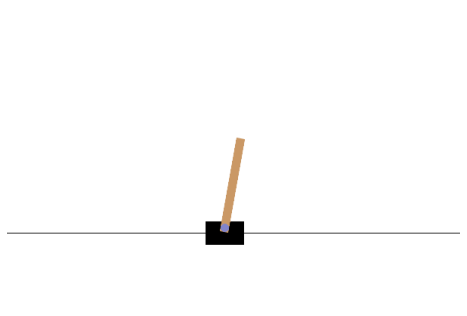

In [46]:
# JSAnimation 설치
!pip install JSAnimation

# 패키지 임포트
import matplotlib.pyplot as plt
from matplotlib import animation
from JSAnimation.IPython_display import display_animation
from IPython.display import HTML

# 애니메이션 재생 정의
def display_frames_as_gif(frames):
  plt.figure(figsize = (frames[0].shape[1] / 72.0, frames[0].shape[0] / 72.0), dpi = 72)
  patch = plt.imshow(frames [0])
  plt.axis('off')

  # 애니메이션 정기 처리
  def animate(i):
    patch.set_data(frames[i])

  anim = animation.FuncAnimation(plt.gcf(), animate, frames = len(frames), interval = 50)
  HTML(anim.to_jshtml())

display_frames_as_gif(frames)

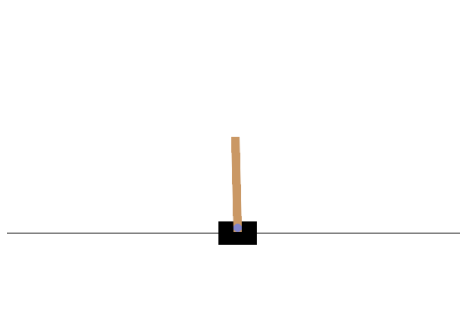

In [62]:
plt.figure(figsize=(frames[0].shape[1] / 72.0, frames[0].shape[0] / 72.0), dpi = 72)
patch = plt.imshow(frames[0])
plt.axis('off')

def animate(i):
    patch.set_data(frames[i])

anim = animation.FuncAnimation(plt.gcf(), animate, frames = len(frames), interval = 50)
HTML(anim.to_jshtml())